## 전이학습 transfer-learning(책 마지막 못한거)

Found 160 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_____________________________________________

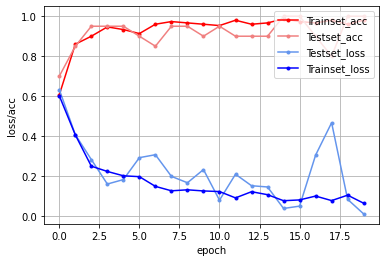

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input, models, layers, optimizers, metrics
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import VGG16

np.random.seed(3)
tf.compat.v1.set_random_seed(3)

# 이미지 증강
train_datagen = ImageDataGenerator(rescale=1./255,
                                  horizontal_flip=True,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  fill_mode='nearest')


train_generator = train_datagen.flow_from_directory(
       './train', # 폴더명
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary') # 2개의 폴더가 있다

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
       'test', # 폴더명
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary')

# 마지막층 사용 여부 include_top : 같은 특징 데이터면 그냥 써도...?
# 28x28, fashion 데이터
transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3)) # 3x3 사이즈 필터 : 고속    
    # 150x150xRGB    
    # 3가지 사용방법 : Non으로 구조만 사용하는 방법
    # weight = 'imagenet'에서 학습한 가중치를 사용하는 방법(now)
    # 개별적으로 학습 가중치의 경로를 입력
    
transfer_model.trainable = False # 가중치 학습여부
transfer_model.summary()

finetune_model = models.Sequential()
finetune_model.add(transfer_model) # 레이어첨부 : 딥러닝화

# FFNN : 치매데이터에 특화
finetune_model.add(Flatten())
finetune_model.add(Dense(64, activation='relu'))
finetune_model.add(Dense(2, activation='softmax')) # 출력값 2개로 : 원핫인코딩 효과
finetune_model.summary()

finetune_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002), 
                       metrics=['accuracy'])

# accuracy, loss, val-loss
history = finetune_model.fit_generator( # fit from generator
       train_generator,
       steps_per_epoch=30, epochs=20, # steps_per_epoch * epochs = 이미지수?
       validation_data=test_generator,
       validation_steps=4)

acc= history.history['accuracy']
val_acc= history.history['val_accuracy']
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, acc, marker='.', c="red", label='Trainset_acc')
plt.plot(x_len, val_acc, marker='.', c="lightcoral", label='Testset_acc')
plt.plot(x_len, y_vloss, marker='.', c="cornflowerblue", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss/acc')
plt.show()

## eager mode & graph mode(static mode)
- 즉시 실행모드
- graph mode (static mode) : constant, variables(가중치), placeholder(주입변수)
    - gpu 메모리 사이즈가 작음(placeholder로 나눠서...)
- 즉시실행모드에서는 placeholder(주입변수)가 함수의 매개변수로 전달(함수 base로 작동)


In [8]:
import tensorflow as tf
print(tf.__version__)
tf.executing_eagerly()

2.3.1


True

In [6]:
import tensorflow as tf
tf.executing_eagerly()
x = [[2.]]
m = tf.matmul(x,x) # 1.x 버전에서는 run, eval => numpy (즉시실행)
print('결과 =, {}'.format(m)) # 디버깅 편하게
print(type(m))

결과 =, [[4.]]
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [11]:
import numpy as np
print(x[0])
print(np.math.sin( x[0][0] ))
print(tf.math.sin( x[0][0] ).numpy()) # 넘파이로 변경

[2.0]
0.9092974268256817
0.9092974


In [12]:
def check_double(max_num):
    counter = tf.constant(0)
    # tensor -> numpy 데이터타입간 변환
    max_num = tf.convert_to_tensor(max_num)#tensorflow -> numpy 호환사용이 가능
    for num in range(1, max_num.numpy()+1):
        num = tf.constant(num)
        if int(num % 3) == 0 and int(num%5) == 0:
            print('3이나 5의 배수')
        elif int(num % 3) == 0 :
            print('3의 배수')
        elif int(num % 5) == 0 :
            print('5의 배수')
        else:
            print(num.numpy())
        counter += 1

In [14]:
check_double(15)

1
2
3의 배수
4
5의 배수
3의 배수
7
8
3의 배수
5의 배수
11
3의 배수
13
14
3이나 5의 배수


In [16]:
w = tf.Variable([[1.0]])
with tf.GradientTape() as tape: # 미분을 위해 값을 저장하는 역할
    loss = w * w # w의 제곱
    
grad = tape.gradient(loss, w) # loss값을 w에 대하여 미분하라
print(grad)

tf.Tensor([[2.]], shape=(1, 1), dtype=float32)


## 함수 base로 작동
- placeholder로 데이터 주입하는것은 함수의 매개변수로 데이터 전달 방식 변경
- 미분도 편미분을 실행하고 가중치를 수정하는 과정을 거침

In [39]:
# 선형회귀 텐서플로
import tensorflow as tf
import numpy as np
rng = np.random
learning_rate = 0.01
training_steps = 1000
display_step = 50
X = np.array([3.3,4.4,5.5,6.71,6.93,4.168,9.779,6.182,7.59,2.167,
              7.042,10.791,5.313,7.997,5.654,9.27,3.1])
Y = np.array([1.7,2.76,2.09,3.19,1.694,1.573,3.366,2.596,2.53,1.221,
              2.827,3.465,1.65,2.904,2.42,2.94,1.3])

n_samples = X.shape[0]   # shape 함수로 array 차원 확인

# 처음 학습에 사용될 Weight와 Bias 값을 랜덤하게 생성
W = tf.Variable(rng.randn(), name="weight")   #  tf.Variable: 텐서플로우 변수 생성
b = tf.Variable(rng.randn(), name="bias")        # rng.randn: 임의의 숫자(난수) 생성


# Linear regression (Wx + b) 수식 정의
def linear_regression(x): # 학습모델
    return W * x + b


# 손실함수인 Mean Square Error (MSE;평균 제곱 오차) 수식 정의
def mean_square(y_pred, y_true): # cost function
    #return tf.reduce_sum(tf.square(y_pred-y_true)) 
    return tf.reduce_sum(tf.pow(y_pred-y_true, 2)) / (2 * n_samples)


# Stochastic Gradient Descent (SGD;확률적경사하강법) 알고리즘
optimizer = tf.optimizers.SGD(learning_rate) # stochastic gradient descent
# 학습 알고리즘 최적화 과정 정의
def run_optimization():
    
    # 텐서플로우는 자동 미분(주어진 입력 변수에 대한 연산의 gradient를 계산하는 것)을 위한 tf.GradientTape 함수 사용
    with tf.GradientTape() as g: # 미분의 구할때는 변화값 필요 - 이전의 데이터가 필요 
        pred = linear_regression(X)
        loss = mean_square(pred, Y)


    # gradients 계산
    gradients = g.gradient(loss, [W, b]) 
        # 변수가 2개 이상 방정식은 일반 미분은 불가 
        # 편미분 : 하나의 변수를 기준으로 나머지를 상수로 가정하고 계산
    
    # gradients에 따라 Weight(W)와 bias(b) 업데이트
    optimizer.apply_gradients(zip(gradients, [W, b]))
# 주어진 스텝에 맞춰 training 시작
for step in range(1, training_steps + 1):
    
    # Weight(W)와 bias(b) 업데이트를 위해 사전 정의된 최적화 과정 실행
    run_optimization()
    
    # display_step(50, 100, 150...)에서 적용 중인 파라미터값 출력
    if step % display_step == 0:
        pred = linear_regression(X)
        loss = mean_square(pred, Y)
        print("step: %i, loss: %f, W: %f, b: %f" % (step, loss, W.numpy(), b.numpy()))

step: 50, loss: 0.230741, W: 0.473984, b: -0.777553
step: 100, loss: 0.213149, W: 0.460883, b: -0.684672
step: 150, loss: 0.197570, W: 0.448554, b: -0.597264
step: 200, loss: 0.183772, W: 0.436951, b: -0.515007
step: 250, loss: 0.171552, W: 0.426032, b: -0.437596
step: 300, loss: 0.160730, W: 0.415756, b: -0.364746
step: 350, loss: 0.151146, W: 0.406086, b: -0.296188
step: 400, loss: 0.142658, W: 0.396986, b: -0.231670
step: 450, loss: 0.135140, W: 0.388422, b: -0.170954
step: 500, loss: 0.128483, W: 0.380362, b: -0.113815
step: 550, loss: 0.122586, W: 0.372777, b: -0.060043
step: 600, loss: 0.117364, W: 0.365639, b: -0.009439
step: 650, loss: 0.112740, W: 0.358922, b: 0.038184
step: 700, loss: 0.108644, W: 0.352601, b: 0.083000
step: 750, loss: 0.105017, W: 0.346652, b: 0.125176
step: 800, loss: 0.101804, W: 0.341053, b: 0.164867
step: 850, loss: 0.098959, W: 0.335784, b: 0.202219
step: 900, loss: 0.096440, W: 0.330826, b: 0.237370
step: 950, loss: 0.094208, W: 0.326160, b: 0.270450
s

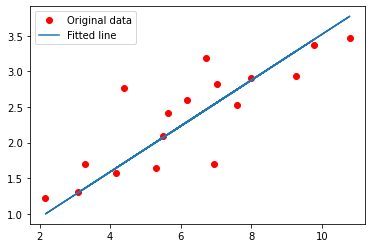

In [40]:
# Linear regression(선형회귀) 결과 시각화
import matplotlib.pyplot as plt   # matplotlib: 차트(chart)나 플롯(plot)으로 데이터를 시각화하는 라이브러리
plt.plot(X, Y, 'ro', label='Original data')
plt.plot(X, np.array(W * X + b), label='Fitted line')
plt.legend()
plt.show()

## 2.3에서 mnist를 학습하는 모델
    - tf.data.Dataset을 이용해서 데이터 피딩
    - scikits 처럼 metrics함수들을 객체화해서 사용
    - 객체화와 객체를 함수처럼 사용할수 있는 방법이 적용(call 함수 오버라이딩 사용)
    - 코드 최적화를 위해 @tf.function 사용

In [25]:
# 기본포맷
import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data() # 필기체 이미지 로드
x_train, x_test = x_train / 255.0, x_test / 255.0

# 채널 차원을 추가합니다.
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

# tf.data를 사용하여 데이터셋을 섞고 배치를 만듭니다:
# mnist.next_batch()
train_ds = tf.data.Dataset.from_tensor_slices( # 데이터를 다루는 방식의 변화
    (x_train, y_train)).shuffle(10000).batch(32) # 10000번 섞고 32묶음씩 데이터피딩
        # 파이썬코어의 제네레이터 사용 : yield 함수를 이용해서 비동기식으로 작동
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [28]:
# 케라스(Keras)의 모델 서브클래싱(subclassing) API를 사용하여 tf.keras 모델을 만듭니다:

# 상속을 이용한 모델정의 - 재사용성 위해
class MyModel(Model): # 클래스를 함수처럼 사용할때 사용
    def __init__(self):
        
        super(MyModel, self).__init__() # 부모의 생성자를 호출
        
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10, activation='softmax')

    def call(self, x): # layer # 함수호출하듯이 사용가능 : 오버라이딩
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x) # 가중치 자동으로 생성
        return self.d2(x) # 32x10

model = MyModel()

In [29]:
#훈련에 필요한 옵티마이저(optimizer)와 손실 함수를 선택합니다:

# scikits 방식을 모방 -> 객체화
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()

#모델의 손실과 성능을 측정할 지표를 선택합니다. 에포크가 진행되는 동안 수집된 측정 지표를 바탕으로 최종 결과를 출력합니다.

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [30]:
# tf.GradientTape를 사용하여 모델을 훈련합니다:

@tf.function # static하게 코드를 최적화 # tf.function(속도보완, 최적화)
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images) # 모델 call function 호출 # 리턴 FFNN결과 32배치x10
        loss = loss_object(labels, predictions) # SparseCategoricalCrossentropy
    gradients = tape.gradient(loss, model.trainable_variables) # trainable_variables : 가중치가 있는것
    optimizer.apply_gradients(zip(gradients, model.trainable_variables)) # 미분 실행후 가중치 수정 : 학습

    train_loss(loss)
    train_accuracy(labels, predictions) # 정확도체크

In [31]:
# 이제 모델을 테스트합니다:

@tf.function
def test_step(images, labels): # 모델 학습 과정이 없음 : loss, accuracy값을 구함
    predictions = model(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [41]:
EPOCHS = 5

for epoch in range(EPOCHS):
    for images, labels in train_ds: # train_ds : from_tensor_slices 로 작성 ( 비동기방식 )
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    template = '에포크: {}, 손실: {}, 정확도: {}, 테스트 손실: {}, 테스트 정확도: {}'
    print (template.format(epoch+1,
                         train_loss.result(), # 객체의 실행결과를 리턴
                         train_accuracy.result()*100,
                         test_loss.result(),
                         test_accuracy.result()*100))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

에포크: 1, 손실: 0.35409578680992126, 정확도: 90.33499908447266, 테스트 손실: 0.18737822771072388, 테스트 정확도: 94.47000122070312
에포크: 2, 손실: 0.26322242617607117, 정확도: 92.6691665649414, 테스트 손실: 0.17504556477069855, 테스트 정확도: 94.68000030517578
에포크: 3, 손실: 0.21845215559005737, 정확도: 93.87222290039062, 테스트 손실: 0.15496927499771118, 테스트 정확도: 95.3066635131836
에포크: 4, 손실: 0.18993742763996124, 정확도: 94.6312484741211, 테스트 손실: 0.14150375127792358, 테스트 정확도: 95.70249938964844
에포크: 5, 손실: 0.16978026926517487, 정확도: 95.177001953125, 테스트 

# 오전 종료 ===================================================